# NEWS Summary

**Generating short length descriptions of news articles.**

<img src="01.jpg" width=800 height=60 />

## Text summarization using machine learning techniques

### A sequence-to-sequence model using an Encoder-Decoder with Attention

The encoder-decoder model for recurrent neural networks is an architecture for sequence-to-sequence prediction problems. It comprised two parts:

**1. Encoder:** The encoder is responsible for stepping through the input time steps, read the input words one by one and encoding the entire sequence into a fixed length vector called a context vector.

**2. Decoder:** The decoder is responsible for stepping through the output time steps while reading from the context vector, extracting the words one by one. The trouble with seq2seq is that the only information that the decoder receives from the encoder is the last encoder hidden state which is like a numerical summary of an input sequence. So, for a long input text, we expect the decoder to use just this one vector representation to output a translation. This might lead to catastrophic forgetting.


To solve this problem, the attention mechanism was developed. 

***Attention*** is proposed as a method to both align and translate. It identifies which parts of the input sequence are relevant to each word in the output (alignment) and use that relevant information to select the right output (translation). So instead of encoding the input sequence into a single fixed context vector (reason for the mentioned bad performance), the attention model develops a context vector that is filtered specifically for each output time step. Attention provides the decoder with information from every encoder hidden state. With this setting, the model can selectively focus on useful parts of the input sequence and hence, learn the alignment between them.

In the next few sections we will go through the whole process: Load the datasets and vector representation, build the vocabulary, define the encoder, decoder and attention mechanism. Then we will code the train stage, iterating over the datasets, and finally we will make the predictions for the validation dataset to get the value of the metrics of interest.


## Content :

The dataset consists of 4515 examples and contains Author_name, Headlines, Url of Article, Short text, Complete Article. I gathered the summarized news from Inshorts and only scraped the news articles from Hindu, Indian times and Guardian. Time period ranges from febrauary to august 2017.


## Data Source :

https://www.kaggle.com/sunnysai12345/news-summary

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import unicodedata
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Layer
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords 
from textblob import TextBlob
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')

## Importing the Dataset

In [2]:
data = pd.read_csv("news_summary.csv", encoding = 'unicode_escape')

In [3]:
data.head()

author                  date  \
0        Chhavi Tyagi  03 Aug 2017,Thursday   
1         Daisy Mowke  03 Aug 2017,Thursday   
2      Arshiya Chopra  03 Aug 2017,Thursday   
3       Sumedha Sehra  03 Aug 2017,Thursday   
4  Aarushi Maheshwari  03 Aug 2017,Thursday   

                                           headlines  \
0  Daman & Diu revokes mandatory Rakshabandhan in...   
1  Malaika slams user who trolled her for 'divorc...   
2  'Virgin' now corrected to 'Unmarried' in IGIMS...   
3  Aaj aapne pakad liya: LeT man Dujana before be...   
4  Hotel staff to get training to spot signs of s...   

                                           read_more  \
0  http://www.hindustantimes.com/india-news/raksh...   
1  http://www.hindustantimes.com/bollywood/malaik...   
2  http://www.hindustantimes.com/patna/bihar-igim...   
3  http://indiatoday.intoday.in/story/abu-dujana-...   
4  http://indiatoday.intoday.in/story/sex-traffic...   

                                                text  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                               ctext  
0  The Daman and Diu administration on Wednesday ...  
1  From her special numbers to TV?appearances, Bo...  
2  The Indira Gandhi Institute of Medical Science...  
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...  
4  Hotels in Mumbai and other Indian cities are t...

In [4]:
data.shape

(4514, 6)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     4514 non-null   object
 1   date       4514 non-null   object
 2   headlines  4514 non-null   object
 3   read_more  4514 non-null   object
 4   text       4514 non-null   object
 5   ctext      4396 non-null   object
dtypes: object(6)
memory usage: 211.7+ KB


In [6]:
data['author'].unique()

array(['Chhavi Tyagi', 'Daisy Mowke', 'Arshiya Chopra', 'Sumedha Sehra',
       'Aarushi Maheshwari', 'Sonu Kumari', 'Parmeet Kaur',
       'Dishant Sharma', 'Ayushi Ahluwalia', 'Niharika Prabhakar',
       'Nandini Sinha', 'Deepali Aggarwal', 'Ankush Verma',
       'Prashanti Moktan', 'Radhika Chugh', 'Manaya Bagga',
       'Tanya Dhingra', 'Krishna Veera Vanamali', 'Mishika Bangia',
       'Saloni Tandon', 'Aditi Verma', 'Anmol Sharma', 'Shifa Naseer',
       'Mansha Mahajan', 'Vani Vivek', 'Swarnim Bagre', 'Rini Sinha',
       'Nihal Thondepu', 'Pragya Swastik', 'Gaurav Shroff',
       'Shubhodeep Datta', 'Ankur Vyas', 'Abhishek Bansal',
       'Tarun Khanna', 'Akshita Jain', 'Sanira Mediratta',
       'Vaibhav Gupta', 'Rini Kapoor', 'Trivedi Bhutnath',
       'Animesh Choudhary', 'Parichit Mainra', 'Yash Kumar',
       'Sultan Mirza', 'Diksha Dhiman', 'Jatan Desai'], dtype=object)

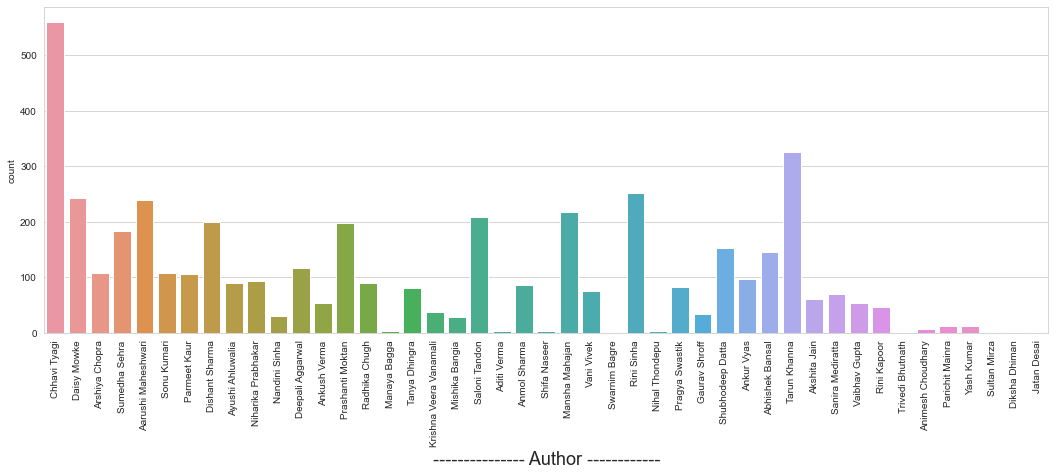

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize = (18, 6))
sns.countplot(data['author'])
plt.xticks(rotation = 90);
plt.xlabel("--------------- Author ------------", fontsize = 18);

* **Chhavi Tyagi** wrote highest number of news headlines which are more than 500
* **Tarun Khanna** wrote second highest number of news headlines which are more than 300

* **Rini Sinha**, **Daisy Mowke**, **Aarushi Maheshwari**, **Mansha Mahajan**, **Saloni Tandon**, **Dishant Sharma**, **Prashanti Moktan**, **Sumedha Sehra**, **Shubhodeep Datta**, **Abhishek Bansal**, **Deepali Aggarwal**, **Arshiya Chopra**, **Sonu Kumari**, **Parmeet Kaur** these are the authors who wrote more than 100 news headlines

* **Jatan Desai**, **Diksha Dhiman**, **Sultan Mirza**, **Trivedi Bhutnath** these are new authors who wrote only 1 headline.

In [8]:
data['date'] = pd.to_datetime(data['date'])

In [9]:
data["day"]      = pd.to_datetime(data['date']).dt.day
data["month"]    = pd.to_datetime(data['date']).dt.month
data["year"]     = pd.to_datetime(data['date']).dt.year
data["weekday"]  = pd.to_datetime(data['date']).dt.weekday

In [10]:
data['weekday'] = data['weekday'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 
                                           6:'Sunday'})

In [11]:
data['month'] = data['month'].replace({1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 
                                       8:'August', 9:'September', 10:'October', 11:'November', 12:'December'})

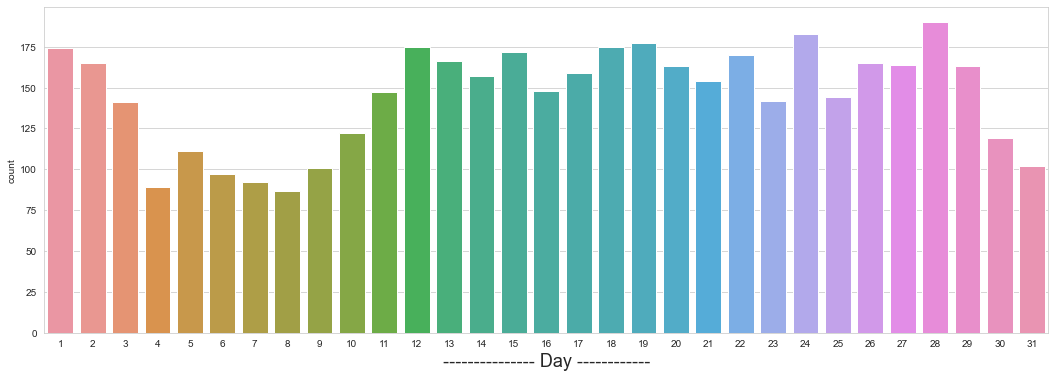

In [12]:
plt.figure(figsize = (18, 6))
sns.countplot(data['day'])
plt.xticks(rotation = 0);
plt.xlabel("--------------- Day ------------", fontsize = 18);

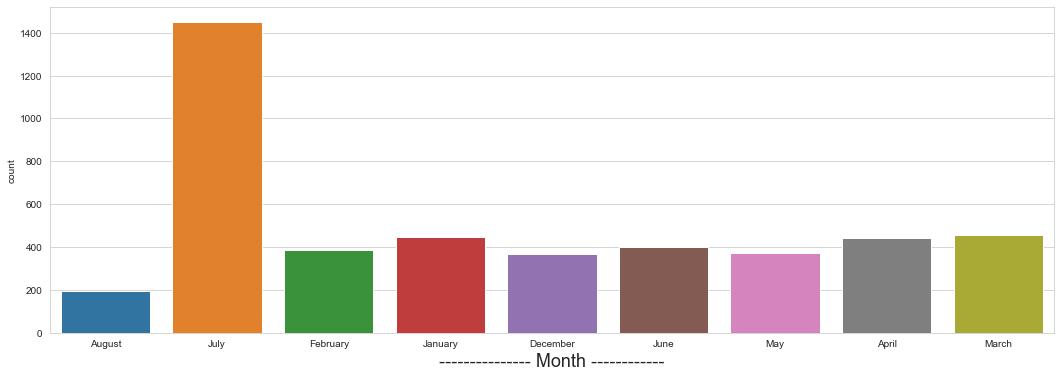

In [13]:
plt.figure(figsize = (18, 6))
sns.countplot(data['month'])
plt.xticks(rotation = 0);
plt.xlabel("--------------- Month ------------", fontsize = 18);

* Maximum news headlines are in **July** month which is more than 1400
* **January**, **March**, **April**, **June** are the months in which morethan 400 news headlines published
* **August** is the month in which least news headline published

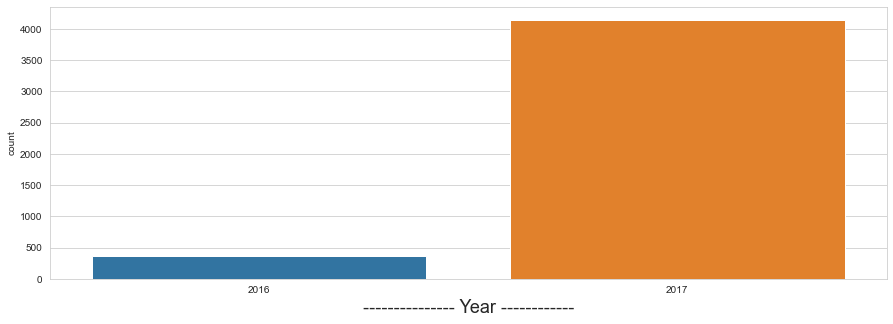

In [14]:
plt.figure(figsize = (15,5))
sns.countplot(data['year'])
plt.xticks(rotation = 0);
plt.xlabel("--------------- Year ------------", fontsize = 18);

* Only **8.2%** news headlines are from **2016**
* **91.8%** news headlines are from **2017**

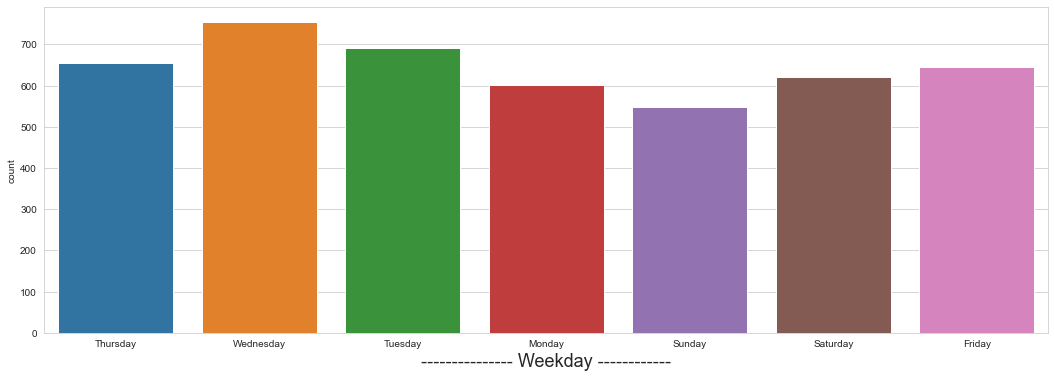

In [15]:
plt.figure(figsize = (18, 6))
sns.countplot(data['weekday'])
plt.xticks(rotation = 0);
plt.xlabel("--------------- Weekday ------------", fontsize = 18);

* Max no of news headlines are in **Wednesday** which is more than 700
* **Tuesday**, **Thursday**, **Friday** have more than 600 news headline
* **Weekend** have least no of news headlines

In [16]:
data.head()

author       date  \
0        Chhavi Tyagi 2017-08-03   
1         Daisy Mowke 2017-08-03   
2      Arshiya Chopra 2017-08-03   
3       Sumedha Sehra 2017-08-03   
4  Aarushi Maheshwari 2017-08-03   

                                           headlines  \
0  Daman & Diu revokes mandatory Rakshabandhan in...   
1  Malaika slams user who trolled her for 'divorc...   
2  'Virgin' now corrected to 'Unmarried' in IGIMS...   
3  Aaj aapne pakad liya: LeT man Dujana before be...   
4  Hotel staff to get training to spot signs of s...   

                                           read_more  \
0  http://www.hindustantimes.com/india-news/raksh...   
1  http://www.hindustantimes.com/bollywood/malaik...   
2  http://www.hindustantimes.com/patna/bihar-igim...   
3  http://indiatoday.intoday.in/story/abu-dujana-...   
4  http://indiatoday.intoday.in/story/sex-traffic...   

                                                text  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                               ctext  day   month  year  \
0  The Daman and Diu administration on Wednesday ...    3  August  2017   
1  From her special numbers to TV?appearances, Bo...    3  August  2017   
2  The Indira Gandhi Institute of Medical Science...    3  August  2017   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...    3  August  2017   
4  Hotels in Mumbai and other Indian cities are t...    3  August  2017   

    weekday  
0  Thursday  
1  Thursday  
2  Thursday  
3  Thursday  
4  Thursday

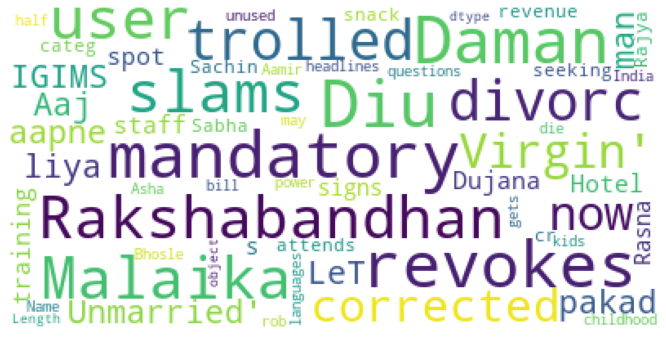

In [17]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color = 'white', max_words = 4500, max_font_size = 40, scale = 1, 
                          random_state = 42).generate(str(data))

    fig = plt.figure(1, figsize = (20,6))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data['headlines'])

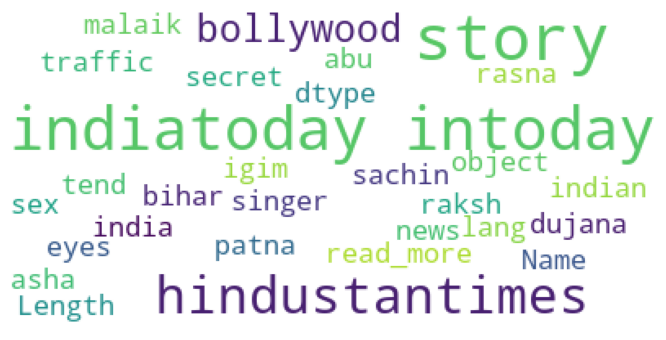

In [18]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color = 'white', max_words = 4500, max_font_size = 40, scale = 1, 
                          random_state = 42).generate(str(data))

    fig = plt.figure(1, figsize = (20,6))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data['read_more'])

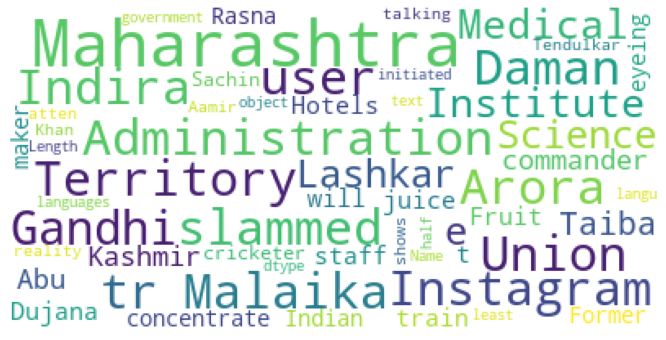

In [19]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color = 'white', max_words = 4500, max_font_size = 40, scale = 1, 
                          random_state = 42).generate(str(data))

    fig = plt.figure(1, figsize = (20,6))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data['text'])

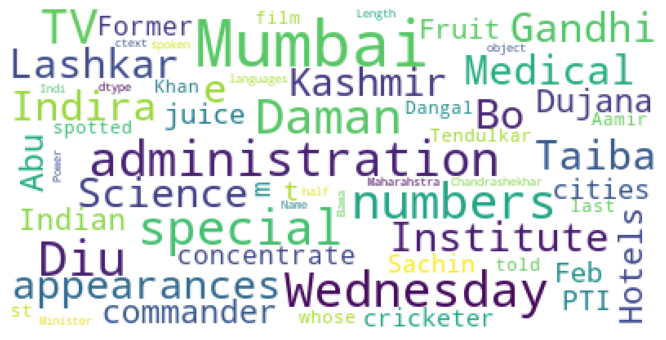

In [20]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color = 'white', max_words = 4500, max_font_size = 40, scale = 1, 
                          random_state = 42).generate(str(data))

    fig = plt.figure(1, figsize = (20,6))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data['ctext'])

In [21]:
data.drop(['date', 'read_more', 'day', 'month', 'year', 'weekday'], axis = 1, inplace = True)

In [22]:
data.head()

author                                          headlines  \
0        Chhavi Tyagi  Daman & Diu revokes mandatory Rakshabandhan in...   
1         Daisy Mowke  Malaika slams user who trolled her for 'divorc...   
2      Arshiya Chopra  'Virgin' now corrected to 'Unmarried' in IGIMS...   
3       Sumedha Sehra  Aaj aapne pakad liya: LeT man Dujana before be...   
4  Aarushi Maheshwari  Hotel staff to get training to spot signs of s...   

                                                text  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                               ctext  
0  The Daman and Diu administration on Wednesday ...  
1  From her special numbers to TV?appearances, Bo...  
2  The Indira Gandhi Institute of Medical Science...  
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...  
4  Hotels in Mumbai and other Indian cities are t...

In [23]:
data['ctext'][0]

'The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Dama

In [24]:
data['ctext'] = data['ctext'].astype("str").astype("string")

## PreProcessing of Text
### Text Normalization
### Removing Html Strips & Noise Text
### Removing Special Characters

In [25]:
data['cleaned_text'] = data['ctext'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex = True)

# Replacing few double spaces with single space
data['cleaned_text'] = data['ctext'].replace("  ", " ")

# remove emoticons form the tweets
data['cleaned_text'] = data['ctext'].replace(r'<ed>', '', regex = True)
data['cleaned_text'] = data['ctext'].replace(r'\B<U+.*>|<U+.*>\B|<U+.*>', '', regex = True)

# convert tweets to lowercase
data['cleaned_text'] = data['ctext'].str.lower()
    
#remove user mentions
data['cleaned_text'] = data['ctext'].replace(r'^(@\w+)', "", regex = True)
    
#remove 'rt' in the beginning
data['cleaned_text'] = data['ctext'].replace(r'^(rt @)', "", regex = True)
    
#remove_symbols
data['cleaned_text'] = data['ctext'].replace(r'[^a-zA-Z0-9]', " ", regex = True)

#remove punctuations 
data['cleaned_text'] = data['ctext'].replace(r'[[]!"#$%\'()\*+,-./:;<=>?^_`{|}]+', "", regex = True)

#remove_URL(x):
data['cleaned_text'] = data['ctext'].replace(r'https.*$', "", regex = True)

#remove 'amp' in the text
data['cleaned_text'] = data['ctext'].replace(r'amp', "", regex = True)

#remove words of length 1 or 2 
data['cleaned_text'] = data['ctext'].replace(r'\b[a-zA-Z]{1,2}\b', '', regex = True)

#remove extra spaces in the tweet
data['cleaned_text'] = data['ctext'].replace(r'^\s+|\s+$', " ", regex = True)

In [26]:
data['cleaned_text'] = data['cleaned_text'].astype("str").astype("string")

### Removing Html Strips & Noise Text

In [27]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on review column
data['cleaned_text'] = data['ctext'].apply(denoise_text)

### Removing Special Characters

In [28]:
def remove_special_characters(text, remove_digits = True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

#Apply function on review column
data['cleaned_text'] = data['ctext'].apply(remove_special_characters)

## Tokenization

In [29]:
tokenizer = ToktokTokenizer()

stopword_list = nltk.corpus.stopwords.words('english')

### Text Stemming

In [30]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

data['cleaned_text'] = data['cleaned_text'].apply(simple_stemmer)

### Removing Stopwords

In [31]:
stop = set(stopwords.words('english'))

def remove_stopwords(text, is_lower_case = False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


data['cleaned_text'] = data['cleaned_text'].apply(remove_stopwords)

### Polarity

In [32]:
data['sentiment'] = data['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
data.head()

author                                          headlines  \
0        Chhavi Tyagi  Daman & Diu revokes mandatory Rakshabandhan in...   
1         Daisy Mowke  Malaika slams user who trolled her for 'divorc...   
2      Arshiya Chopra  'Virgin' now corrected to 'Unmarried' in IGIMS...   
3       Sumedha Sehra  Aaj aapne pakad liya: LeT man Dujana before be...   
4  Aarushi Maheshwari  Hotel staff to get training to spot signs of s...   

                                                text  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                               ctext  \
0  The Daman and Diu administration on Wednesday ...   
1  From her special numbers to TV?appearances, Bo...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Mumbai and other Indian cities are t...   

                                        cleaned_text  sentiment  
0  daman diu administr wednesday withdrew circula...   0.012951  
1  special number tvappear bollywood actor malaik...   0.375837  
2  indira gandhi institut medic scienc igim patna...  -0.114685  
3  lashkaretaiba kashmir command abu dujana wa ki...   0.154100  
4  hotel mumbai indian citi train staff spot sign...   0.005492

In [33]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
data['sentiments'] = data['sentiment'].apply(getAnalysis )

In [34]:
data.head()

author                                          headlines  \
0        Chhavi Tyagi  Daman & Diu revokes mandatory Rakshabandhan in...   
1         Daisy Mowke  Malaika slams user who trolled her for 'divorc...   
2      Arshiya Chopra  'Virgin' now corrected to 'Unmarried' in IGIMS...   
3       Sumedha Sehra  Aaj aapne pakad liya: LeT man Dujana before be...   
4  Aarushi Maheshwari  Hotel staff to get training to spot signs of s...   

                                                text  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                               ctext  \
0  The Daman and Diu administration on Wednesday ...   
1  From her special numbers to TV?appearances, Bo...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Mumbai and other Indian cities are t...   

                                        cleaned_text  sentiment sentiments  
0  daman diu administr wednesday withdrew circula...   0.012951   Positive  
1  special number tvappear bollywood actor malaik...   0.375837   Positive  
2  indira gandhi institut medic scienc igim patna...  -0.114685   Negative  
3  lashkaretaiba kashmir command abu dujana wa ki...   0.154100   Positive  
4  hotel mumbai indian citi train staff spot sign...   0.005492   Positive

In [35]:
data['sentiments'].value_counts()

Positive    3074
Negative    1199
Neutral      241
Name: sentiments, dtype: int64

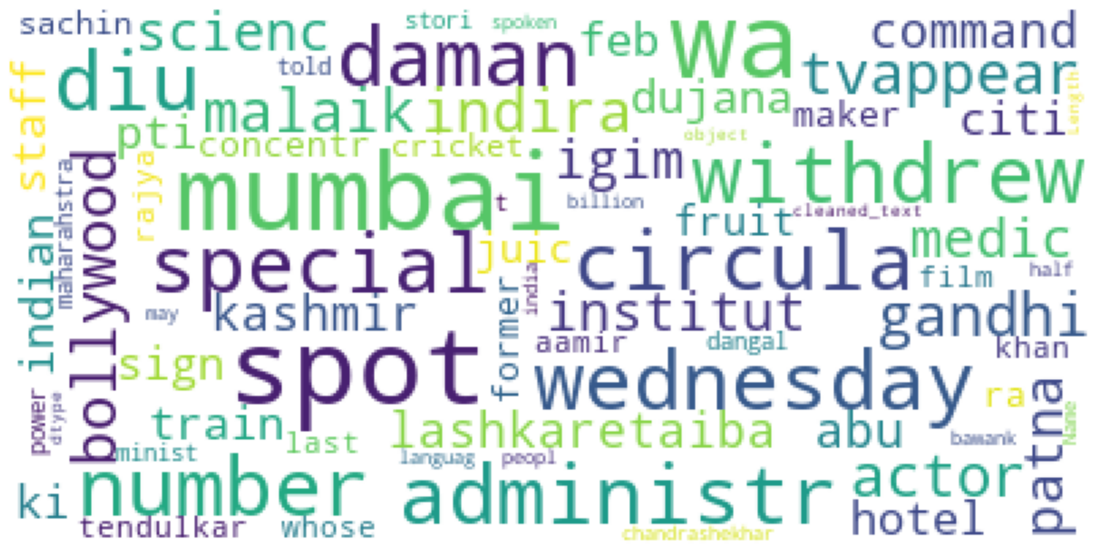

In [36]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color = 'white', max_words = 4500, max_font_size = 40, scale = 1, 
                          random_state = 42).generate(str(data))

    fig = plt.figure(1, figsize = (20,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data['cleaned_text'])

In [37]:
from PIL import Image

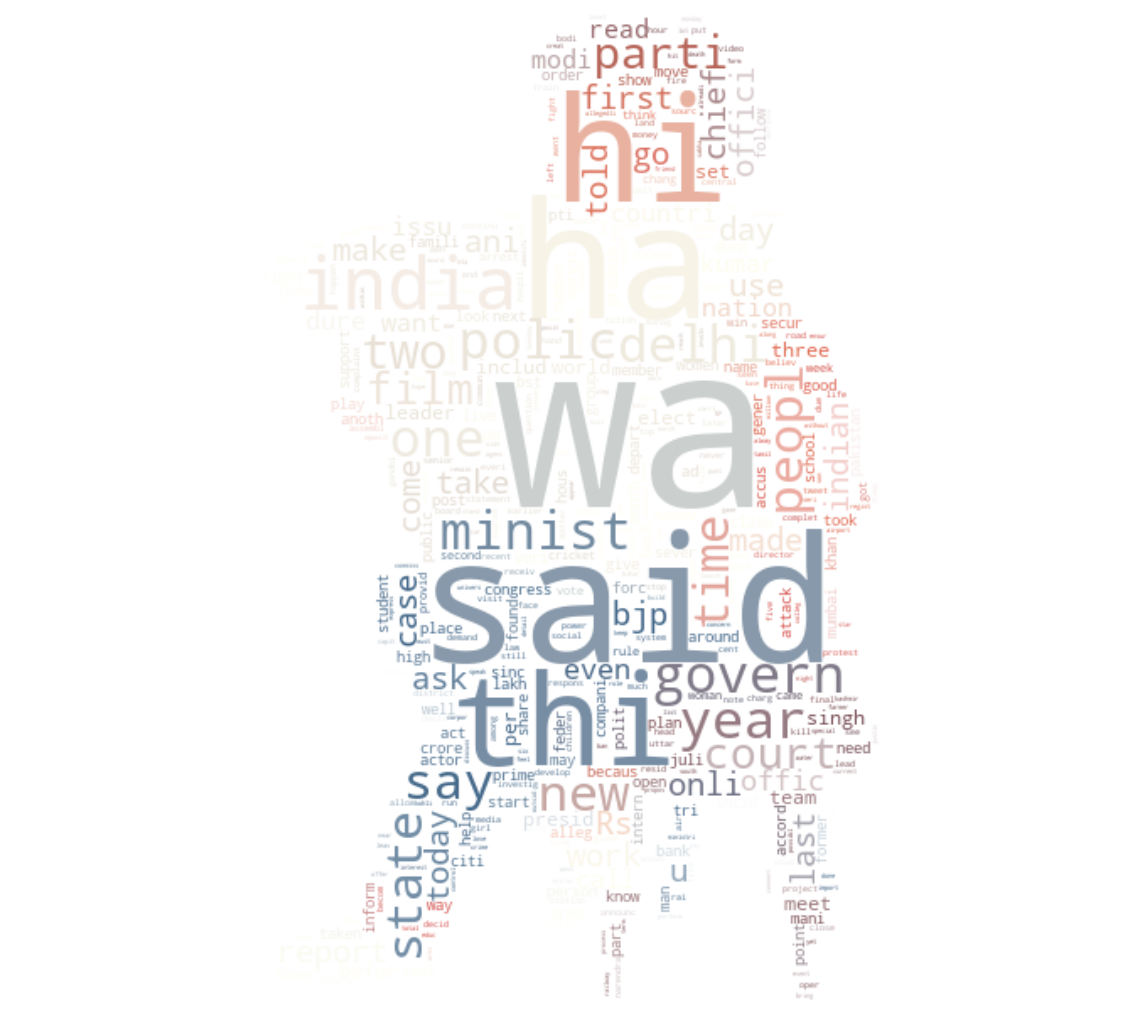

In [38]:
stopwords = set(STOPWORDS)
mask = np.array(Image.open(r"D:\Projects\News Summary\04.JPG"))
wordcloud = WordCloud(width = 3000, height = 2000, random_state = 1, background_color = 'white', colormap = 'Set2', 
                      collocations = False, mode = "RGBA", max_words = 4000, 
                      mask = mask).generate(' '.join(data['cleaned_text']))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize = [20,20])
plt.imshow(wordcloud.recolor(color_func = image_colors), interpolation = "bilinear")
plt.axis("off") 
plt.show()

https://www.analyticsvidhya.com/blog/2021/08/creating-customized-word-cloud-in-python/

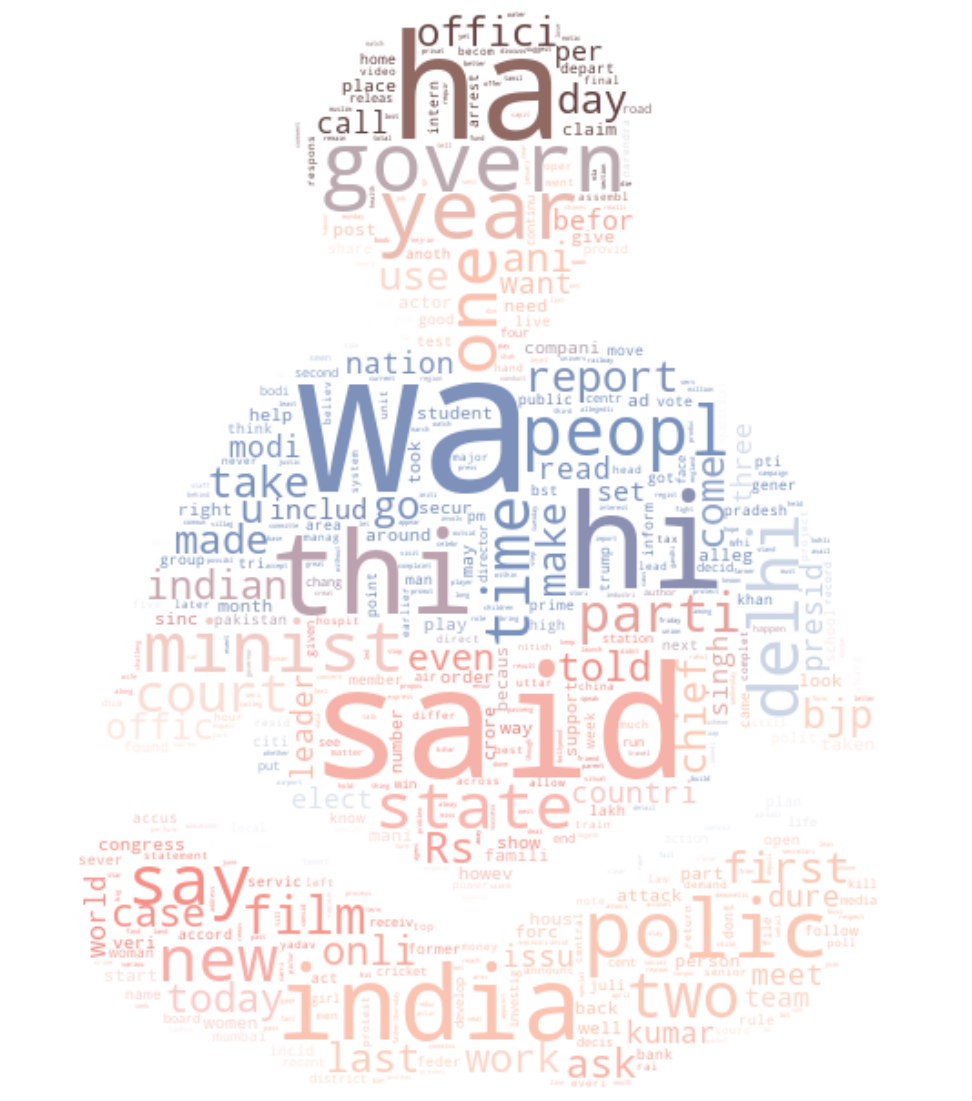

In [39]:
mask = np.array(Image.open(r"D:\Projects\News Summary\05.JPG"))
wordcloud = WordCloud(width = 3000, height = 2000, random_state = 1, background_color = 'white', colormap = 'Set2', 
                      collocations = False, mode = "RGBA", max_words = 4000, 
                      mask = mask).generate(' '.join(data['cleaned_text']))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize = [20,20])
plt.imshow(wordcloud.recolor(color_func = image_colors), interpolation = "bilinear")
plt.axis("off") 
plt.show()

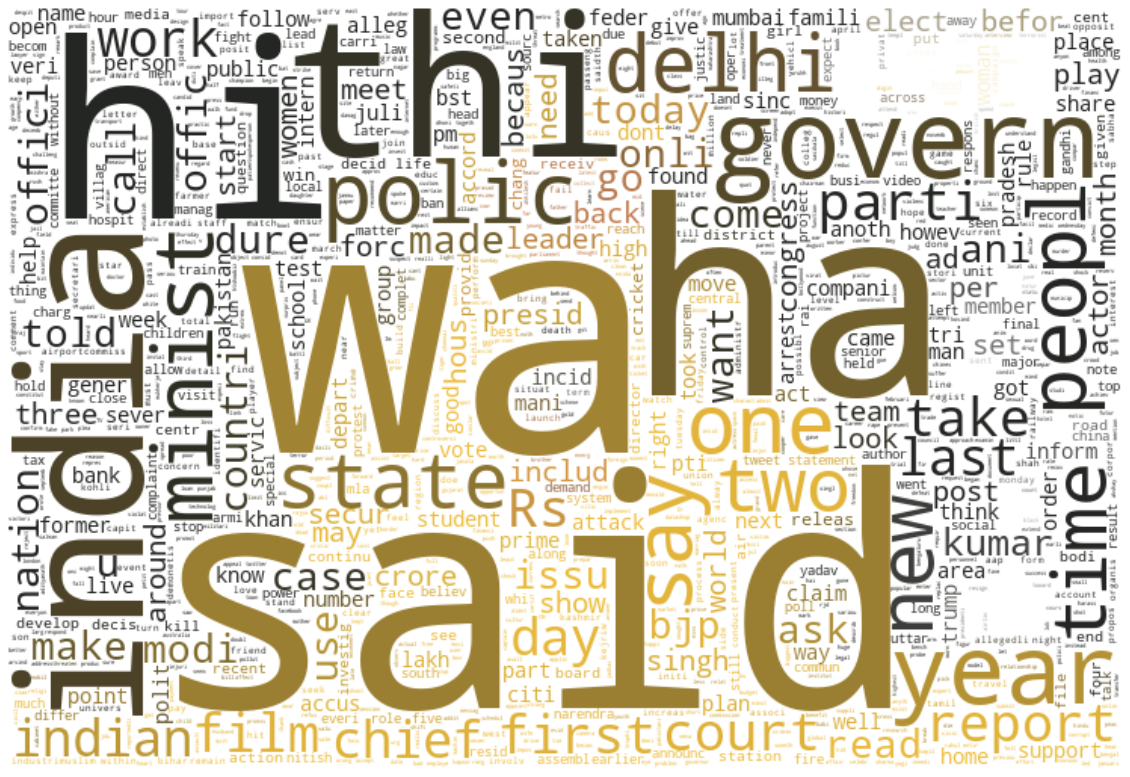

In [40]:
mask = np.array(Image.open(r"D:\Projects\News Summary\08.JPG"))
wordcloud = WordCloud(width = 3000, height = 2000, random_state = 1, background_color = 'white', colormap = 'Set2', 
                      collocations = False, mode = "RGBA", max_words = 4000, 
                      mask = mask).generate(' '.join(data['cleaned_text']))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize = [20,20])
plt.imshow(wordcloud.recolor(color_func = image_colors), interpolation = "bilinear")
plt.axis("off") 
plt.show()

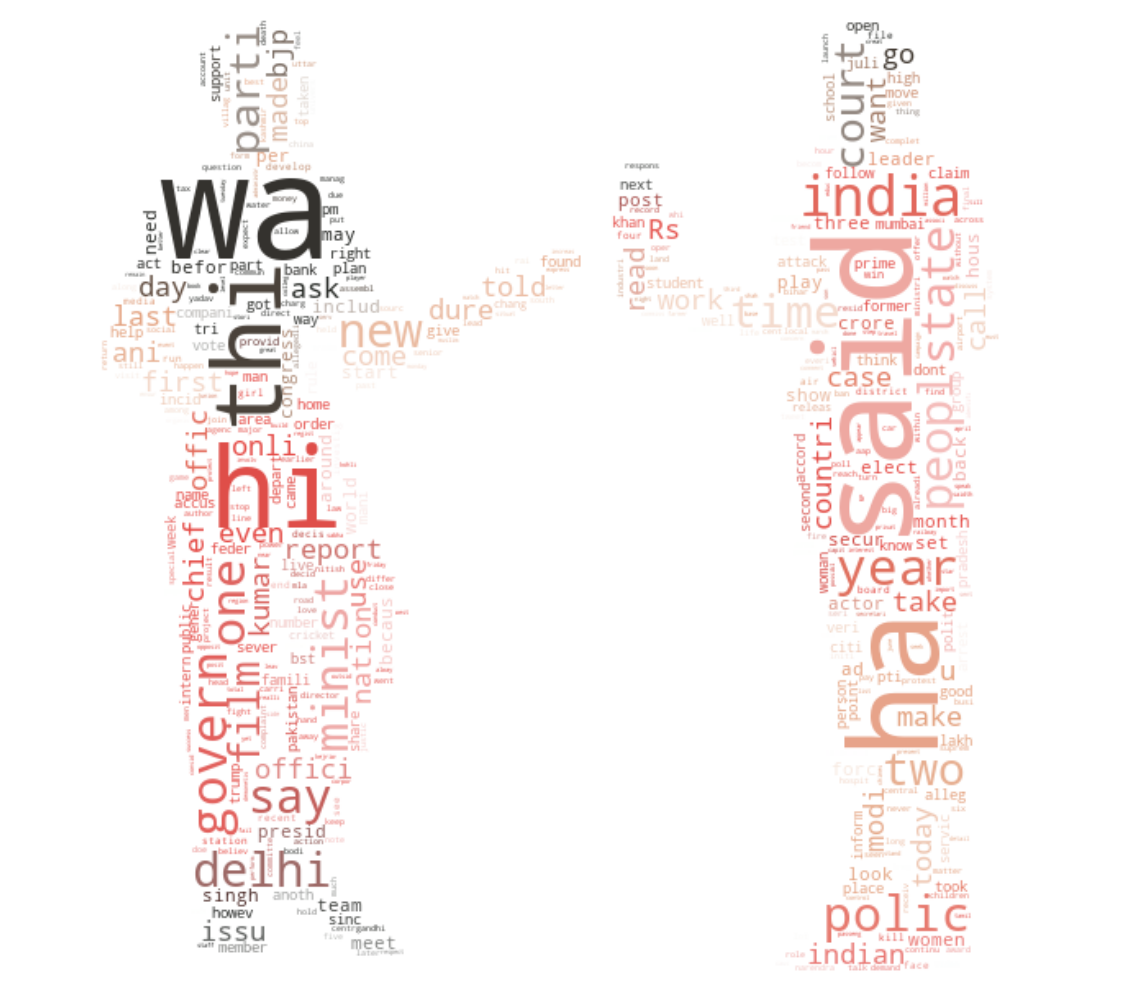

In [41]:
mask = np.array(Image.open(r"D:\Projects\News Summary\07.JPG"))
wordcloud = WordCloud(width = 3000, height = 2000, random_state = 1, background_color = 'white', colormap = 'Set2', 
                      collocations = False, mode = "RGBA", max_words = 4000, 
                      mask = mask).generate(' '.join(data['cleaned_text']))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize = [20,20])
plt.imshow(wordcloud.recolor(color_func = image_colors), interpolation = "bilinear")
plt.axis("off") 
plt.show()

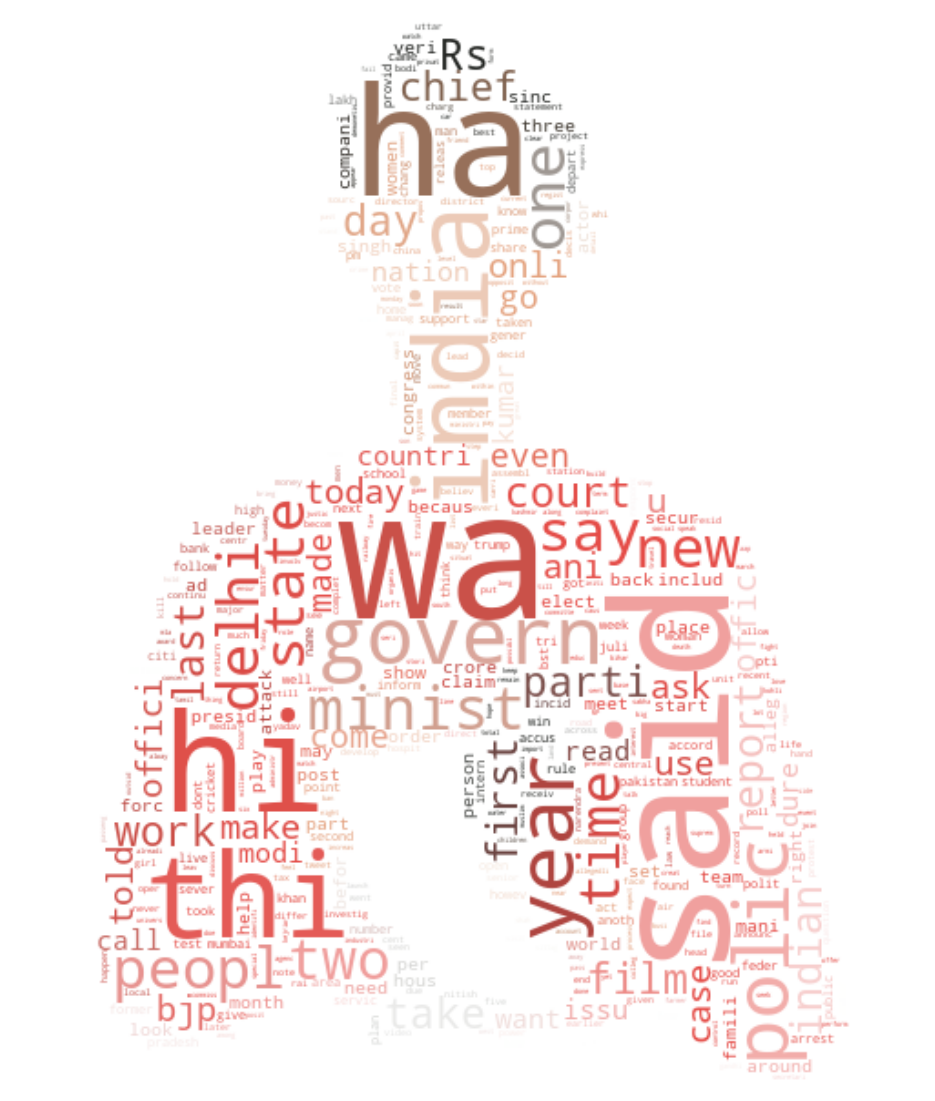

In [42]:
mask = np.array(Image.open(r"D:\Projects\News Summary\06.JPG"))
wordcloud = WordCloud(width = 3000, height = 2000, random_state = 1, background_color = 'white', colormap = 'Set2', 
                      collocations = False, mode = "RGBA", max_words = 4000, 
                      mask = mask).generate(' '.join(data['cleaned_text']))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize = [20,20])
plt.imshow(wordcloud.recolor(color_func = image_colors), interpolation = "bilinear")
plt.axis("off") 
plt.show()

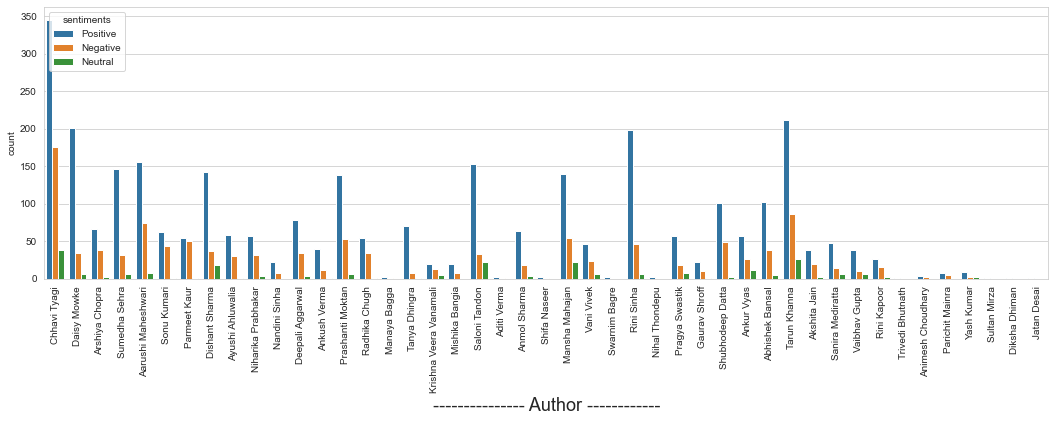

In [43]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,5))
sns.countplot(data['author'], hue = data['sentiments'])
plt.xticks(rotation = 90);
plt.xlabel("--------------- Author ------------", fontsize = 18);

* most of the headlines form the author show **Positive Sentiments** 
* **Sonu Kumari**, **Parmeet Kaur**, **Radhika Chugh**, **Krishna Veera Vanamali**, **Rini Kapoor** & **Parichit Maira** these authors have almost equal ratio of **Positive - Negative Sentiments**

In [44]:
data.head()

author                                          headlines  \
0        Chhavi Tyagi  Daman & Diu revokes mandatory Rakshabandhan in...   
1         Daisy Mowke  Malaika slams user who trolled her for 'divorc...   
2      Arshiya Chopra  'Virgin' now corrected to 'Unmarried' in IGIMS...   
3       Sumedha Sehra  Aaj aapne pakad liya: LeT man Dujana before be...   
4  Aarushi Maheshwari  Hotel staff to get training to spot signs of s...   

                                                text  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                               ctext  \
0  The Daman and Diu administration on Wednesday ...   
1  From her special numbers to TV?appearances, Bo...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Mumbai and other Indian cities are t...   

                                        cleaned_text  sentiment sentiments  
0  daman diu administr wednesday withdrew circula...   0.012951   Positive  
1  special number tvappear bollywood actor malaik...   0.375837   Positive  
2  indira gandhi institut medic scienc igim patna...  -0.114685   Negative  
3  lashkaretaiba kashmir command abu dujana wa ki...   0.154100   Positive  
4  hotel mumbai indian citi train staff spot sign...   0.005492   Positive

### TF-IDF usage

In [45]:
corpus = data.cleaned_text  ## Collection of documents 
vectorizer = TfidfVectorizer(stop_words = 'english', analyzer = 'word')
print(vectorizer)

X = vectorizer.fit_transform(corpus)
print(X[:5]) 

TfidfVectorizer(stop_words='english')
  (0, 16474)	0.049664688386016766
  (0, 13207)	0.047727147947433365
  (0, 10920)	0.027263806354667013
  (0, 55094)	0.048458775348745674
  (0, 8825)	0.031905101740116446
  (0, 12309)	0.044370846389413326
  (0, 63712)	0.03355576342560415
  (0, 38209)	0.032789119807876695
  (0, 11870)	0.08220296120101364
  (0, 50500)	0.03368931002176193
  (0, 43112)	0.04240921294595389
  (0, 28935)	0.05719716885512335
  (0, 21702)	0.07510622424626669
  (0, 61997)	0.04544250893967494
  (0, 34894)	0.03238677227187711
  (0, 17672)	0.04523284098712373
  (0, 46702)	0.03962253947253186
  (0, 63870)	0.050910673596598906
  (0, 54264)	0.04808642787106273
  (0, 39818)	0.027062465843737137
  (0, 50904)	0.01389507806018229
  (0, 11303)	0.07184575890010415
  (0, 38283)	0.059153273990019135
  (0, 14738)	0.026164767223220028
  (0, 50432)	0.10861510455625484
  :	:
  (4, 17052)	0.029528709896075898
  (4, 59958)	0.03315636765889358
  (4, 50049)	0.02585671679107908
  (4, 44988)	0.022174

In [46]:
idf = vectorizer.idf_
print(idf)

[7.46925032 7.33571892 8.72201329 ... 8.72201329 8.72201329 8.72201329]


In [47]:
vectorizer.vocabulary_

{'daman': 18003,
 'diu': 20077,
 'administr': 6690,
 'wednesday': 63498,
 'withdrew': 64070,
 'circular': 15136,
 'ask': 9186,
 'women': 64146,
 'staff': 55833,
 'tie': 59166,
 'rakhi': 47728,
 'male': 35922,
 'colleagu': 15701,
 'order': 42084,
 'trigger': 60232,
 'backlash': 10013,
 'employe': 21502,
 'wa': 63029,
 'rip': 49804,
 'apart': 8549,
 'social': 55006,
 'mediath': 37047,
 'union': 61324,
 'territori': 58352,
 'forc': 24019,
 'retreat': 49483,
 '24': 2889,
 'hour': 28311,
 'issu': 30645,
 'compulsori': 16131,
 'celebr': 13974,
 'rakshabandhan': 47738,
 'workplaceit': 64250,
 'ha': 26524,
 'decid': 18514,
 'festiv': 23220,
 'august': 9544,
 'thi': 58832,
 'connect': 16393,
 'offic': 41448,
 'depart': 19022,
 'shall': 53475,
 'remain': 48953,
 'open': 41940,
 'collect': 15710,
 'suitabl': 56903,
 'time': 59237,
 'ladi': 33738,
 'gurpreet': 26451,
 'singh': 54392,
 'deputi': 19092,
 'secretari': 52694,
 'personnel': 44017,
 'saidto': 51402,
 'ensur': 21705,
 'skip': 54648,
 'at

In [48]:
vectorizer.get_feature_names()

['00',
 '000',
 '00000',
 '000000',
 '0000003',
 '0001',
 '0002',
 '0005',
 '0007',
 '0009',
 '0017',
 '0025',
 '0032',
 '005',
 '007',
 '00howev',
 '00lukaku',
 '01',
 '010',
 '0100',
 '01072017',
 '011',
 '012',
 '0125',
 '013',
 '015',
 '0161',
 '017',
 '019',
 '02',
 '02244',
 '023',
 '024',
 '027',
 '0295',
 '03',
 '030',
 '03041000',
 '033',
 '036',
 '037',
 '03891000',
 '04',
 '040',
 '042',
 '044',
 '0445',
 '047sec',
 '048',
 '05',
 '0514',
 '0530',
 '0556',
 '0559',
 '05pm',
 '06',
 '0600',
 '0608',
 '0613',
 '0619',
 '0621000',
 '0623',
 '0629',
 '0631',
 '0637',
 '0645',
 '0652',
 '0655',
 '0659',
 '07',
 '0700',
 '0704',
 '0706',
 '0712',
 '0715',
 '0718',
 '0720',
 '0721',
 '0722',
 '0724',
 '0728',
 '0731',
 '0733',
 '0736',
 '073sec',
 '0740',
 '0741',
 '0743',
 '0745',
 '0749',
 '075',
 '0754',
 '0755',
 '0757',
 '076',
 '078',
 '0786',
 '079',
 '07mm',
 '08',
 '0800',
 '0801',
 '0805',
 '08061000the',
 '0811',
 '0814',
 '0815',
 '0819',
 '0824',
 '0826',
 '0829',
 '08

In [49]:
col = ['feat_'+ i for i in vectorizer.get_feature_names()]
print(col[1:5])
print(X[1:5])

['feat_000', 'feat_00000', 'feat_000000', 'feat_0000003']
  (0, 28460)	0.038737013454470094
  (0, 45468)	0.03910092616704137
  (0, 45019)	0.0800209503836353
  (0, 23180)	0.06852735595017104
  (0, 17064)	0.03899546987666072
  (0, 45046)	0.04519886950002034
  (0, 7113)	0.038386986405505155
  (0, 63333)	0.03781636130998951
  (0, 28015)	0.03342965381943261
  (0, 20222)	0.03629080312031706
  (0, 15243)	0.027390215692728866
  (0, 16155)	0.033458279727992646
  (0, 44003)	0.027098934204215153
  (0, 26869)	0.030474253543281583
  (0, 22333)	0.0800209503836353
  (0, 8520)	0.03804982419335096
  (0, 21672)	0.04186487724097031
  (0, 61905)	0.05350295649122525
  (0, 14910)	0.04193683522749588
  (0, 13155)	0.04394803767620682
  (0, 40053)	0.026775008442415305
  (0, 22647)	0.03380894392382061
  (0, 62979)	0.07630097172309652
  (0, 19637)	0.05802122940483986
  (0, 61851)	0.059862302015002755
  :	:
  (3, 17052)	0.029528709896075898
  (3, 59958)	0.03315636765889358
  (3, 50049)	0.02585671679107908
  (3, 4